In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Matplotlib is building the font cache; this may take a moment.


In [3]:
df = pd.read_csv('../data/raw/IMDB_Dataset.csv')

print("="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print("\n" + "="*50)
print("DATA INFORMATION")
print("="*50)
print(df.info())

print("\n" + "="*50)
print("MISSING VALUES")
print("="*50)
print(df.isnull().sum())
print(f"\nPercentage of missing values:")
print(df.isnull().sum() / len(df) * 100)

print("\n" + "="*50)
print("SENTIMENT DISTRIBUTION")
print("="*50)
print(df['sentiment'].value_counts())
print(f"\nPercentage distribution:")
print(df['sentiment'].value_counts(normalize=True) * 100)

DATASET OVERVIEW

Dataset Shape: (50000, 2)

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

DATA INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

MISSING VALUES
review       0
sentiment    0
dtype: int64

Percentage of missing values:
review       0.0
sentiment    0.0
dtype: float64

SENTIMENT DISTRIBUTION
sentiment
positive    25000
negative    25000
Name: count, dtype: int

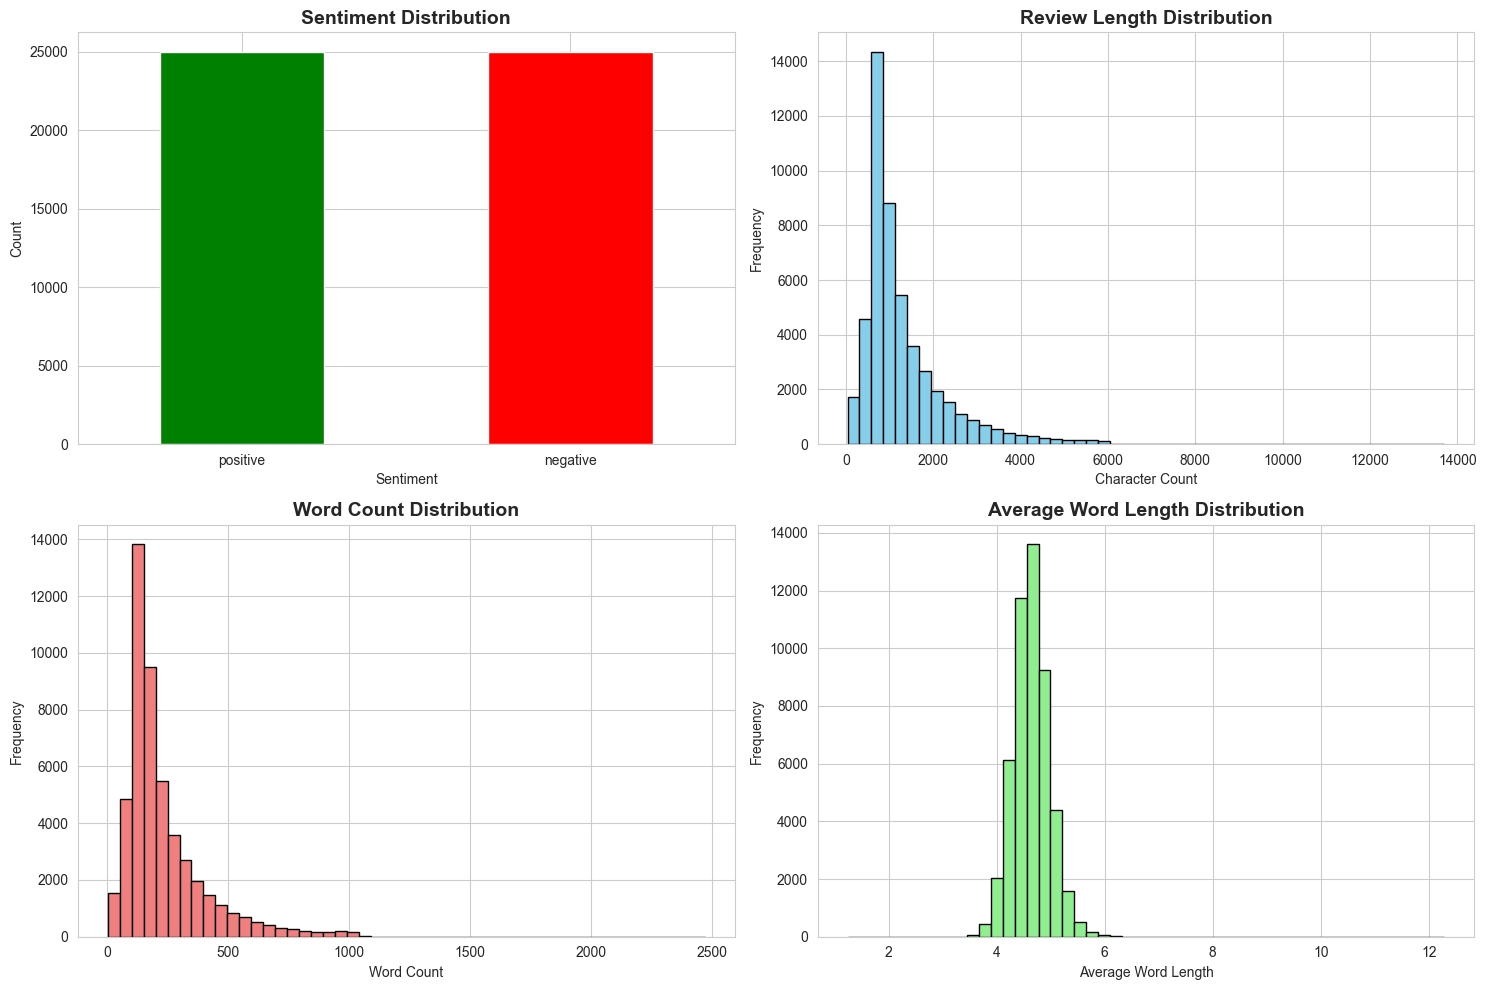

In [5]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Sentiment Distribution
df['sentiment'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['green', 'red'])
axes[0, 0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sentiment')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# 2. Review Length Distribution
df['review_length'] = df['review'].apply(len)
df['review_length'].hist(bins=50, ax=axes[0, 1], color='skyblue', edgecolor='black')
axes[0, 1].set_title('Review Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Frequency')

# 3. Word Count Distribution
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))
df['word_count'].hist(bins=50, ax=axes[1, 0], color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')

# 4. Average Word Length
df['avg_word_length'] = df['review'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
df['avg_word_length'].hist(bins=50, ax=axes[1, 1], color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Average Word Length Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Word Length')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../data/processed/eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
print("\n" + "="*50)
print("STATISTICAL SUMMARY")
print("="*50)
print(df[['review_length', 'word_count', 'avg_word_length']].describe())


STATISTICAL SUMMARY
       review_length    word_count  avg_word_length
count   50000.000000  50000.000000     50000.000000
mean     1309.431020    231.156940         4.640676
std       989.728014    171.343997         0.340731
min        32.000000      4.000000         1.239865
25%       699.000000    126.000000         4.417904
50%       970.000000    173.000000         4.627006
75%      1590.250000    280.000000         4.847458
max     13704.000000   2470.000000        12.290909


In [7]:
# Sentiment-wise statistics
print("\n" + "="*50)
print("SENTIMENT-WISE STATISTICS")
print("="*50)
print(df.groupby('sentiment')[['review_length', 'word_count', 'avg_word_length']].mean())


SENTIMENT-WISE STATISTICS
           review_length  word_count  avg_word_length
sentiment                                            
negative      1294.06436   229.46456         4.623461
positive      1324.79768   232.84932         4.657892


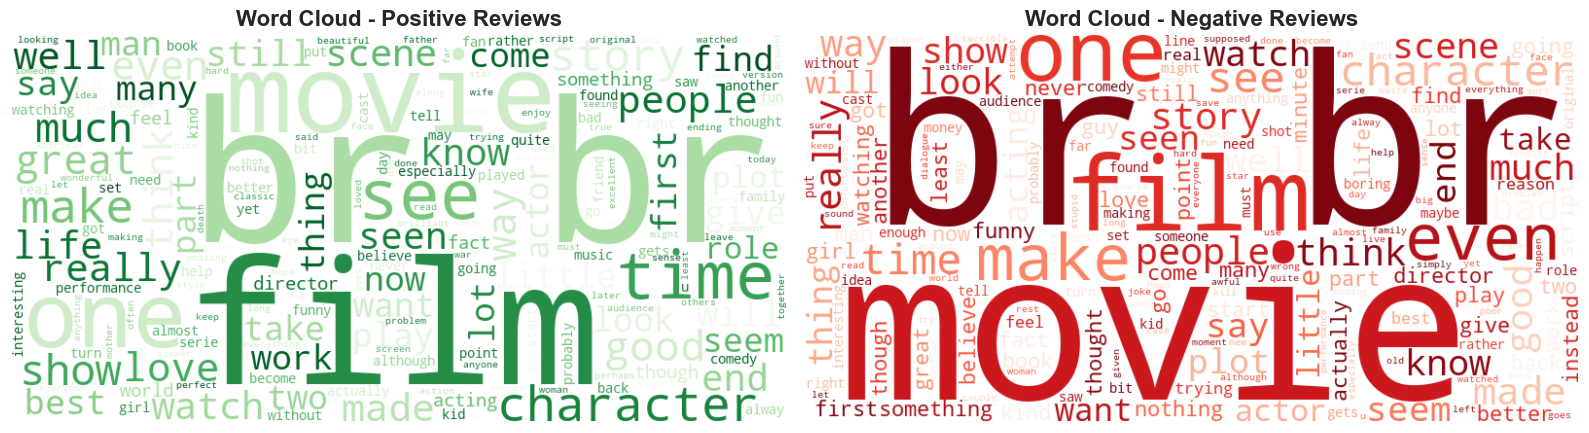

In [8]:
# Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive reviews
positive_text = ' '.join(df[df['sentiment'] == 'positive']['review'].values)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', 
                          colormap='Greens').generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('Word Cloud - Positive Reviews', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Negative reviews
negative_text = ' '.join(df[df['sentiment'] == 'negative']['review'].values)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', 
                          colormap='Reds').generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('Word Cloud - Negative Reviews', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../data/processed/wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Most common words
def get_top_words(text_series, n=20):
    words = ' '.join(text_series).lower().split()
    words = [word for word in words if len(word) > 3]  # Filter short words
    return Counter(words).most_common(n)

In [10]:
print("\n" + "="*50)
print("TOP 20 WORDS - POSITIVE REVIEWS")
print("="*50)
top_pos = get_top_words(df[df['sentiment'] == 'positive']['review'])
for word, count in top_pos:
    print(f"{word}: {count}")


TOP 20 WORDS - POSITIVE REVIEWS
this: 64167
that: 63908
/><br: 48976
with: 44418
film: 29367
movie: 26681
have: 24169
from: 20350
they: 17669
like: 16331
very: 15791
it's: 15574
about: 15557
some: 13978
when: 13967
just: 13715
what: 13570
more: 13543
their: 12177
good: 11814


In [11]:
print("\n" + "="*50)
print("TOP 20 WORDS - NEGATIVE REVIEWS")
print("="*50)
top_neg = get_top_words(df[df['sentiment'] == 'negative']['review'])
for word, count in top_neg:
    print(f"{word}: {count}")


TOP 20 WORDS - NEGATIVE REVIEWS
this: 74316
that: 66232
/><br: 51998
with: 40172
movie: 34811
have: 30254
film: 25719
they: 23191
like: 20950
just: 20544
from: 18972
about: 16841
some: 16187
it's: 15638
there: 14663
even: 14596
what: 14438
would: 13522
only: 12980
when: 12937


In [12]:
# Save processed data with additional features
df.to_csv('../data/processed/data_with_features.csv', index=False)
print("\n✓ Data with features saved to '../data/processed/data_with_features.csv'")


✓ Data with features saved to '../data/processed/data_with_features.csv'
